## VAE and InfoVAE on a bimodal gaussian distribution
A closer look at real-world data from eruptions at the Old Faithful in Yellowstone.

Eruption durations and wait time between eruptions at the Old Faithful approximately follow a bimodal gaussian distribution.

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sts
import torch
import torch.nn as nn
import torch.utils.data as tdata
from em import em_gaussian_mixture
from old_faithful import get_old_faithful_data

from vaes_ptorch import GaussianModel, GaussianVAE, TrainArgs, get_mlp, train
from vaes_ptorch.args import DivAnnealing

In [2]:
save_path = os.path.expanduser("~/vaes_ptorch/data")
er, waits = get_old_faithful_data(save=True, save_dir=save_path)

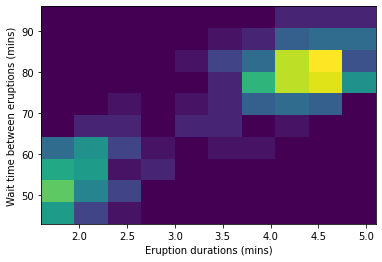

In [3]:
plt.hist2d(er, waits, alpha=1.0)
plt.xlabel("Eruption durations (mins)")
plt.ylabel("Wait time between eruptions (mins)");

(272, 2)

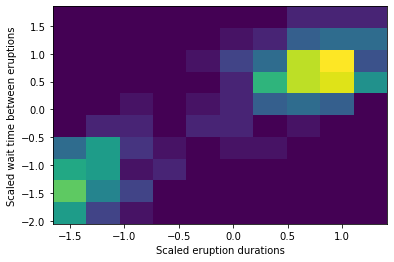

In [4]:
def scale_data(data):  # of shape n, p
    mean_, std_ = data.mean(0), data.std(0)
    return (data - mean_) / std_, (mean_, std_)


data = np.concatenate([er.reshape(-1, 1), waits.reshape(-1, 1)], 1)
data, _ = scale_data(data)
plt.hist2d(data[:, 0], data[:, 1], alpha=1.0)
plt.xlabel("Scaled eruption durations")
plt.ylabel("Scaled wait time between eruptions")
data.shape

In [5]:
theta = em_gaussian_mixture(data, 2, 1000)
theta

Theta(mu=[array([-1.27396762, -1.20991826]), array([0.7038525 , 0.66846596])], sigma=[array([[0.05329039, 0.02814822],
       [0.02814822, 0.18299437]]), array([[0.13095257, 0.06084201],
       [0.06084201, 0.19575032]])], gamma=array([0.35587286, 0.64412714]))

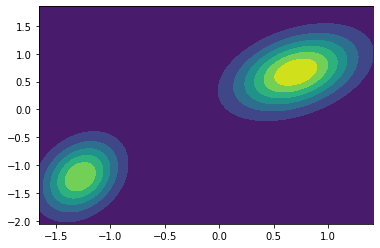

In [6]:
x = np.linspace(data[:, 0].min(), data[:, 0].max(), num=100)
y = np.linspace(data[:, 1].min(), data[:, 1].max(), num=100)
X, Y = np.meshgrid(x, y)

XY = np.concatenate([X[:, :, np.newaxis], Y[:, :, np.newaxis]], axis=-1)

pdfs = (
    sts.multivariate_normal.pdf(XY, theta.mu[0], theta.sigma[0])
    * theta.gamma[0]
    + sts.multivariate_normal.pdf(XY, theta.mu[1], theta.sigma[1])
    * theta.gamma[1]
)

plt.contourf(X, Y, pdfs)

In [7]:
data_dim = 2
latent_dim = 1

h_size = 128
h_layers = 5

lr = 1e-3
batch_size = 256
num_epochs = 500

print_every = 100

info_vae = True
# info_vae = False
# start_scale = 0.005
# end_scale = 0.005
start_scale = 1.0
end_scale = 1.0
start_epochs = 0
linear_epochs = 0

In [8]:
dataset = tdata.TensorDataset(torch.from_numpy(data).float())
dataloader = tdata.DataLoader(
    dataset=dataset, batch_size=batch_size, shuffle=True
)

In [9]:
encoder = GaussianModel(
    model=get_mlp(
        in_dim=data_dim, out_dim=2 * latent_dim, h_dims=[h_size] * h_layers,
    ),
    out_dim=latent_dim,
    min_var=1e-2,
)
decoder = GaussianModel(
    model=get_mlp(
        in_dim=latent_dim, out_dim=2 * data_dim, h_dims=[h_size] * h_layers,
    ),
    out_dim=data_dim,
    min_var=0.0,
)
vae = GaussianVAE(encoder=encoder, decoder=decoder)
optimizer = torch.optim.Adam(params=vae.parameters(), lr=lr)
train_args = TrainArgs(
    info_vae=info_vae,
    num_epochs=num_epochs,
    div_annealing=DivAnnealing(
        start_epochs=start_epochs,
        linear_epochs=linear_epochs,
        start_scale=start_scale,
        end_scale=end_scale,
    ),
    print_every=print_every,
    smoothing=0.9,
)

In [10]:
train(data=dataloader, vae=vae, optimizer=optimizer, args=train_args)

Step: 0 | Loss: 0.50645 | Div scale: 1.000
NLL: 0.50410 | MMD-div: 0.00235
Step: 100 | Loss: 0.11770 | Div scale: 1.000
NLL: 0.06904 | MMD-div: 0.02809
Step: 200 | Loss: 0.08047 | Div scale: 1.000
NLL: 0.03929 | MMD-div: 0.01051
Step: 300 | Loss: 0.08987 | Div scale: 1.000
NLL: 0.03130 | MMD-div: 0.02193
Step: 400 | Loss: 0.06494 | Div scale: 1.000
NLL: 0.03242 | MMD-div: 0.01588
Step: 500 | Loss: 0.06442 | Div scale: 1.000
NLL: 0.03014 | MMD-div: 0.01868
Step: 600 | Loss: 0.07210 | Div scale: 1.000
NLL: 0.02925 | MMD-div: 0.00723
Step: 700 | Loss: 0.05688 | Div scale: 1.000
NLL: 0.02455 | MMD-div: 0.00420
Step: 800 | Loss: 0.06196 | Div scale: 1.000
NLL: 0.02521 | MMD-div: 0.00249
Step: 900 | Loss: 0.08163 | Div scale: 1.000
NLL: 0.03267 | MMD-div: 0.01419


In [11]:
def plot_pdf_2d(xs, ys, zs, conditional_dist):
    mu, var = conditional_dist(zs)
    mu, var = mu.detach().numpy(), var.detach().numpy()
    X, Y = np.meshgrid(xs, ys)
    XY = np.concatenate([X[:, :, np.newaxis], Y[:, :, np.newaxis]], axis=-1)

    pdfs = np.zeros_like(X)
    for ix in range(mu.shape[0]):
        pdf_ix = sts.multivariate_normal.pdf(XY, mu[ix], np.sqrt(var[ix]))
        pdfs += pdf_ix
    pdfs /= mu.shape[0]
    plt.contourf(X, Y, pdfs)


n_monte_carlo_samples = 1000

### Inference

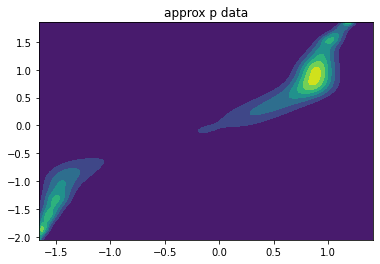

In [12]:
x_grid = np.linspace(data[:, 0].min(), data[:, 0].max(), num=100)
y_grid = np.linspace(data[:, 1].min(), data[:, 1].max(), num=100)
z_samples = torch.randn((n_monte_carlo_samples, 1))

vae.eval()
with torch.no_grad():
    plt.figure()
    plot_pdf_2d(x_grid, y_grid, z_samples, vae.decoder)
    plt.title("approx p data")
    plt.show()
    plt.close()

### Generation

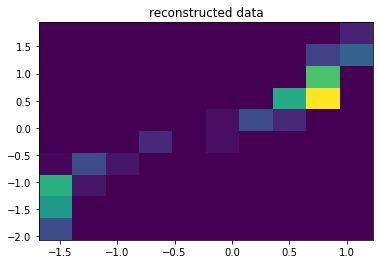

In [13]:
vae.eval()
with torch.no_grad():
    plt.figure()
    out = vae(torch.from_numpy(data).float())
    reconstructed = out.mu_x + torch.sqrt(out.sig_x) * torch.randn_like(
        out.sig_x
    )
    reconstructed = reconstructed.detach().numpy()
    plt.hist2d(reconstructed[:, 0], reconstructed[:, 1], alpha=1.0)
    plt.title("reconstructed data")
    plt.show()
    plt.close()